In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
#contain many datasets like Mnist,also contains transformation of images for
#pre process datas
from torchvision import datasets, transforms

In [2]:
#normalization part:here we make our data to be between 1 and -1
#images are 28*28=784 pixels range 0 to 255
#transform it from an array to Tensor.
#compose make a chain of transforms
#transforms.ToTensor() make tensor float num range 0 to 1
#now we normalize this as first mean (0.5,0.5,0.5) and second one standard deviation of (ch,h,w)
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
#initialize MNIST dataset
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#training loader which we use for batches
#shuffle will change  subset of trainig data change every iteration and save us from local minima
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [3]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [4]:
#for plotting we have to convert image from tensor back to numpy arr
def im_convert(tensor):
    image = tensor.clone().detach().numpy() #first dim chanel second w third h
    #its single color channel because its b and W so its 1*28*28
    #channel=1 and w=28 and h=28
    image = image.transpose(1, 2, 0) #we make it 28*28*1
    #denormalizing part:
    #subtracting the mean and devide by standard deviation
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    #change range back to 0 to 1
    image = image.clip(0, 1)
    return image


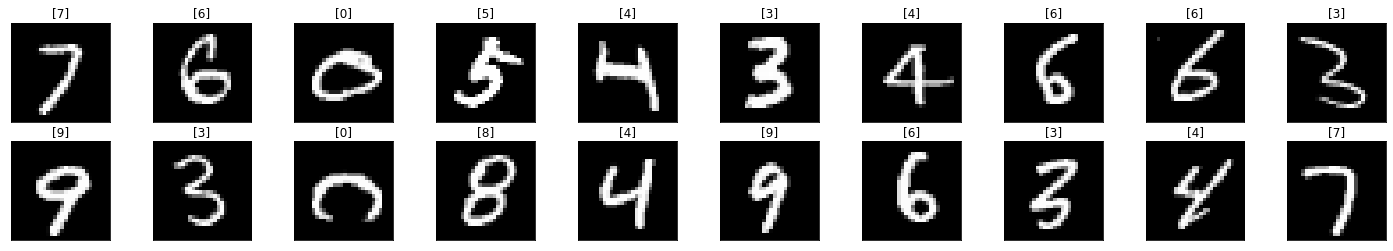

In [5]:
#loading image
#training loader which we use for batches
#iter will create an object that alows us to go iterable training_loader one elemnt at a time
#below ia a visualization of our training data
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [6]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        #for multi class classification we use crossentropy loss
        #in this cases we dont feed last layer outputs to an activation function
        #instead we use raw output and we call them as "Scores"
        x = self.linear3(x)
        return x

In [7]:
#each image is 784 so this is input size
#out put size is num of classes
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [8]:
#we use this for multiclass classification
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [9]:
#note that every batch is 1000 here
epochs = 15
running_loss_history = []
running_corrects_history = []#accuracy
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
  
  
    for inputs, labels in training_loader:
        #reshape and flattening image
        #1,28,28 we make it 1 dim as 784==>1,784...we let the ch dim be there
        inputs = inputs.view(inputs.shape[0], -1)#slice 784
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)#max score is the class we use it in running_corrects
        #runing loss is accumulated for every batch
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)#if the predict is true
        
    else:
        with torch.no_grad():#because we will not use gradients in val part
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        #len(training_loader) is num of batches
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)#it gives us avg accuracy at that epoch
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))#e stars at zero we want at 1
        
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        
    
      
       
   

       
    

epoch : 1
training loss: 0.9609, acc 76.1950 
validation loss: 0.4347, validation acc 88.6000 
epoch : 2
training loss: 0.3848, acc 89.2533 
validation loss: 0.3308, validation acc 90.4000 
epoch : 3
training loss: 0.3230, acc 90.7050 
validation loss: 0.2928, validation acc 91.4500 
epoch : 4
training loss: 0.2917, acc 91.4067 
validation loss: 0.2687, validation acc 92.3700 
epoch : 5
training loss: 0.2686, acc 92.0983 
validation loss: 0.2506, validation acc 92.7800 
epoch : 6
training loss: 0.2466, acc 92.7950 
validation loss: 0.2368, validation acc 93.2000 
epoch : 7
training loss: 0.2281, acc 93.4200 
validation loss: 0.2175, validation acc 93.6100 
epoch : 8
training loss: 0.2100, acc 93.9467 
validation loss: 0.1983, validation acc 94.3300 
epoch : 9
training loss: 0.1951, acc 94.4367 
validation loss: 0.1856, validation acc 94.5200 
epoch : 10
training loss: 0.1807, acc 94.7800 
validation loss: 0.1771, validation acc 94.7200 
epoch : 11
training loss: 0.1691, acc 95.1167 
va

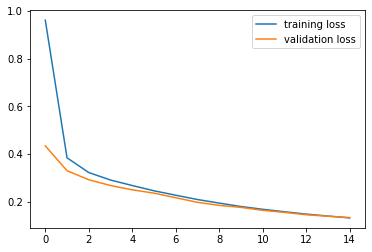

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

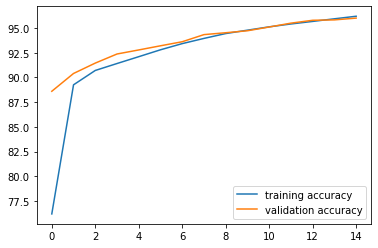

In [11]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()